In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from skbio.stats.ordination import pcoa
#from skbio import TreeNode
#from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from scipy.spatial.distance import braycurtis, pdist, squareform
from torchmetrics.regression import MeanSquaredError, MeanAbsolutePercentageError
import warnings
from collections import Counter
import scipy.stats
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import NMF

In [2]:
%cd /home/zuzannak/MicroFormer/

/home/zuzannak/MicroFormer


/home/zuzannak/MicroFormer/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# Load and preprocess pathways data
pathways = (
    pd.read_csv('inputs/pathways_relab.csv', index_col=0, low_memory=False)
    .fillna(0)
    .sort_index()
)

# Load and preprocess metadata
metadata = pd.read_csv('inputs/metadata.csv', index_col=0, low_memory=False).sort_index()

# Filter pathways by removing subjects with very low pathway counts
pathways_sum = pathways.astype(bool).astype(int).sum(axis=1).sort_values()
threshold = pathways_sum.quantile(0.1)
pathways_keep_subjects = pathways_sum[pathways_sum > threshold].index
pathways = pathways.loc[pathways_keep_subjects]

# Align metadata with filtered pathways
metadata = metadata[metadata['sample_id'].isin(pathways.index)]

# Add a binary SICK column to metadata
metadata['SICK'] = np.where(metadata['disease'] == 'healthy', 0, 1)

# Select sample groups
healthy_kids_samples = (
    metadata[(metadata['SICK'] == 0) & (metadata['age'] < 5)]
    .drop_duplicates('sample_id', keep='first')
    .sample(100, random_state=32)['sample_id']
    .tolist()
)

healthy_samples = (
    metadata[metadata['SICK'] == 0]
    .drop_duplicates('sample_id', keep='first')
    .sample(3000, random_state=32)['sample_id']
    .tolist()
)

sick_samples = (
    metadata[(metadata['age'] > 5) & (metadata['SICK'] == 1)]
    .drop_duplicates('sample_id', keep='first')
    .sample(2000, random_state=32)['sample_id']
    .tolist()
)

# Combine samples to keep
keep_samples = healthy_samples  # Change this to healthy_kids_samples or sick_samples as needed

# Filter pathways for selected samples and drop NaN values
pathways = pathways.loc[keep_samples].iloc[:, 2:].dropna()

In [29]:
# remove pathways that are present in 90% of subjects
#filtered_pathways = pathways[[col for col in pathways.columns if col not in h_pathways_100prc.pathway.values]]
#filtered_pathways = filtered_pathways.div(filtered_pathways.sum(axis=1), axis=0).dropna()

In [6]:
## Filter low abundance bacteria
def filter_prevalence(df, treshold = 0.1):
    '''features as columns'''
    df_binary = df.copy()
    df_binary[df_binary>0]=1
    df_binary_sum = df_binary.sum(axis=0)
    
    keep_features = df_binary_sum[df_binary_sum > df.shape[0]*treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

def filter_on_abundance(df, abundance_treshold = 1e-3):
    '''features as columns'''
    df_relab = df.div(df.sum(axis=1), axis=0)
    df_relab_mean = df_relab.mean()

    keep_features = df_relab_mean[df_relab_mean > abundance_treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

filtered_pathways = filter_prevalence(pathways)
filtered_pathways = filtered_pathways.div(filtered_pathways.sum(axis=1), axis=0).dropna()

In [58]:
# Function to categorize pathways based on their prevalence
def get_range_pathways(pathways, keep_samples):
    # Calculate the count of samples in which each pathway is present
    pathways_bool_df = (
        pathways.astype(bool)
        .astype(int)
        .sum()
        .sort_values()
        .reset_index()
        .rename(columns={"index": "pathway", 0: "count"})
    )
    
    # Filter pathways present in more than 5 samples
    pathways_bool_df = pathways_bool_df[pathways_bool_df['count'] > 5]
    
    # Define thresholds for pathway prevalence
    total_samples = len(keep_samples)
    pathways_1prc = pathways_bool_df[pathways_bool_df['count'] < int(total_samples * 0.01)]
    pathways_5prc = pathways_bool_df[
        (pathways_bool_df['count'] >= int(total_samples * 0.01)) & 
        (pathways_bool_df['count'] < int(total_samples * 0.05))
    ]
    pathways_10prc = pathways_bool_df[
        (pathways_bool_df['count'] >= int(total_samples * 0.05)) & 
        (pathways_bool_df['count'] < int(total_samples * 0.10))
    ]
    pathways_50prc = pathways_bool_df[
        (pathways_bool_df['count'] >= int(total_samples * 0.10)) & 
        (pathways_bool_df['count'] < int(total_samples * 0.50))
    ]
    pathways_90prc = pathways_bool_df[
        (pathways_bool_df['count'] >= int(total_samples * 0.50)) & 
        (pathways_bool_df['count'] < int(total_samples * 0.90))
    ]
    pathways_100prc = pathways_bool_df[pathways_bool_df['count'] >= int(total_samples * 0.90)]
    
    # Return the categorized pathways
    return pathways_1prc, pathways_5prc, pathways_10prc, pathways_50prc, pathways_90prc, pathways_100prc

# Categorize pathways for the healthy samples group
h_pathways_1prc, h_pathways_5prc, h_pathways_10prc, h_pathways_50prc, h_pathways_90prc, h_pathways_100prc = get_range_pathways(filtered_pathways, healthy_samples)

# NMF

In [7]:
def evaluate_nmf_generalization_direct(X_train, X_test, n_components, random_state=42):
    """
    Evaluate NMF generalization when using fit_transform directly.
    
    Parameters:
    -----------
    X_train : training data matrix
    X_test : test data matrix
    n_components : number of components for NMF
    random_state : random seed for reproducibility
    
    Returns:
    --------
    dict containing evaluation metrics
    """
    # Fit NMF on training data
    nmf_model = NMF(
        n_components=n_components,
        init='random',
        random_state=random_state,
        max_iter=5000
    )
    
    # Get W and H matrices for training data
    W_train = nmf_model.fit_transform(X_train * 100)
    H_train = nmf_model.components_
    
    # Transform test data
    W_test = nmf_model.transform(X_test * 100)
    
    # Normalize matrices
    H_train = H_train / H_train.sum(axis=1)[:, np.newaxis]
    
    # Calculate reconstruction error
    train_reconstruction = np.dot(W_train, H_train)
    test_reconstruction = np.dot(W_test, H_train)
    
    train_error = mean_squared_error(X_train * 100, train_reconstruction)
    test_error = mean_squared_error(X_test * 100, test_reconstruction)
    
    # Get dominant patterns
    dominant_patterns_train = np.argmax(W_train, axis=1)
    dominant_patterns_test = np.argmax(W_test, axis=1)
    
    # Calculate pattern correlations
    pattern_correlations = []
    for i in range(n_components):
        train_pattern = H_train[i, :]
        test_pattern = np.average(X_test, weights=W_test[:, i], axis=0)
        corr, _ = spearmanr(train_pattern, test_pattern)
        pattern_correlations.append(corr)
    
    return {
        'train_reconstruction_error': train_error,
        'test_reconstruction_error': test_error,
        'pattern_correlations': np.mean(pattern_correlations),
        'W_train': W_train,
        'W_test': W_test,
        'H': H_train,
        'dominant_patterns_train': dominant_patterns_train,
        'dominant_patterns_test': dominant_patterns_test,
        'n_components':n_components
    }

In [8]:
## Run Kfold NMF
data = filtered_pathways.values.copy()

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
NMF_res = pd.DataFrame()

for n_components in range(2, 8):
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data)):
        # Split data
        X_train = data[train_idx]
        X_test = data[test_idx]

        results = evaluate_nmf_generalization_direct(X_train, X_test, n_components)
        df = pd.DataFrame({k: [v] for k, v in results.items()})
        df['fold'] = fold_idx
        NMF_res = pd.concat([NMF_res, df])

<Axes: xlabel='n_components', ylabel='test_reconstruction_error'>

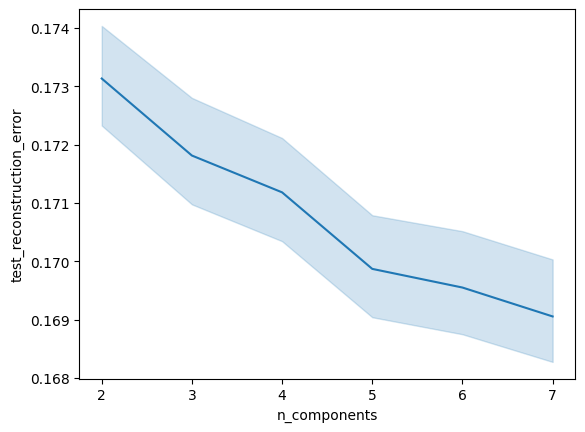

In [9]:
sns.lineplot(x = NMF_res.n_components, y = NMF_res.test_reconstruction_error)

<Axes: xlabel='n_components', ylabel='train_reconstruction_error'>

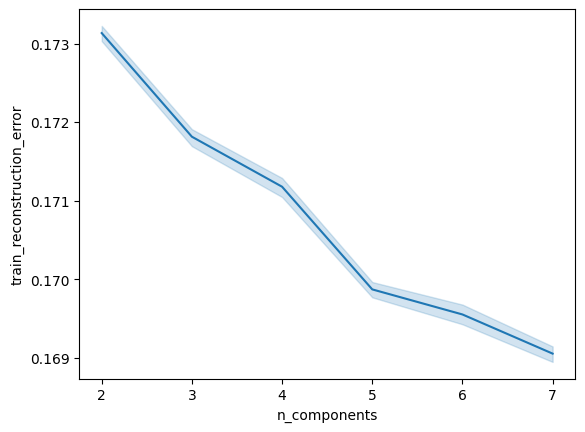

In [10]:
sns.lineplot(x = NMF_res.n_components, y = NMF_res.train_reconstruction_error)

<Axes: xlabel='n_components', ylabel='pattern_correlations'>

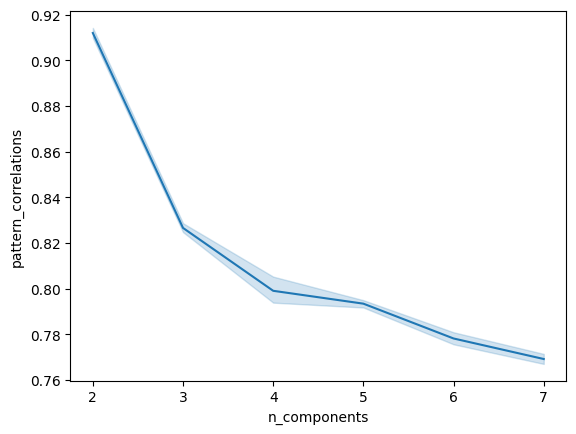

In [11]:
sns.lineplot(x = NMF_res.n_components, y = NMF_res.pattern_correlations)

In [13]:
### Run NMF on 3 components

X_train_pathways, X_test_pathways = train_test_split(filtered_pathways, test_size=0.2, random_state=0)
res = evaluate_nmf_generalization_direct(X_train_pathways, X_test_pathways, 5)

/home/zuzannak/MicroFormer/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/zuzannak/MicroFormer/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


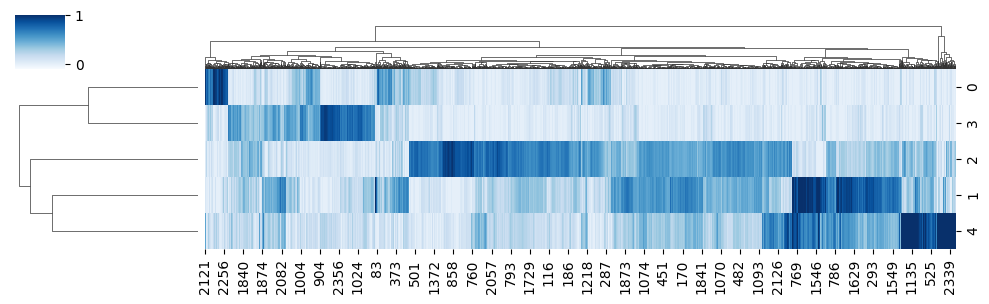

In [14]:
sns.clustermap(res['W_train'].T, figsize = (10, 3), cmap = 'Blues', vmax = 0, vmin=1)

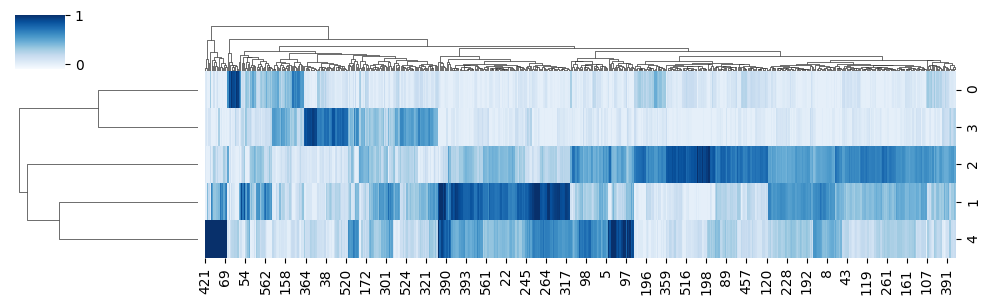

In [15]:
sns.clustermap(res['W_test'].T, figsize = (10, 3), cmap = 'Blues', vmax = 0, vmin=1)

## Plot functions contribution in each topic

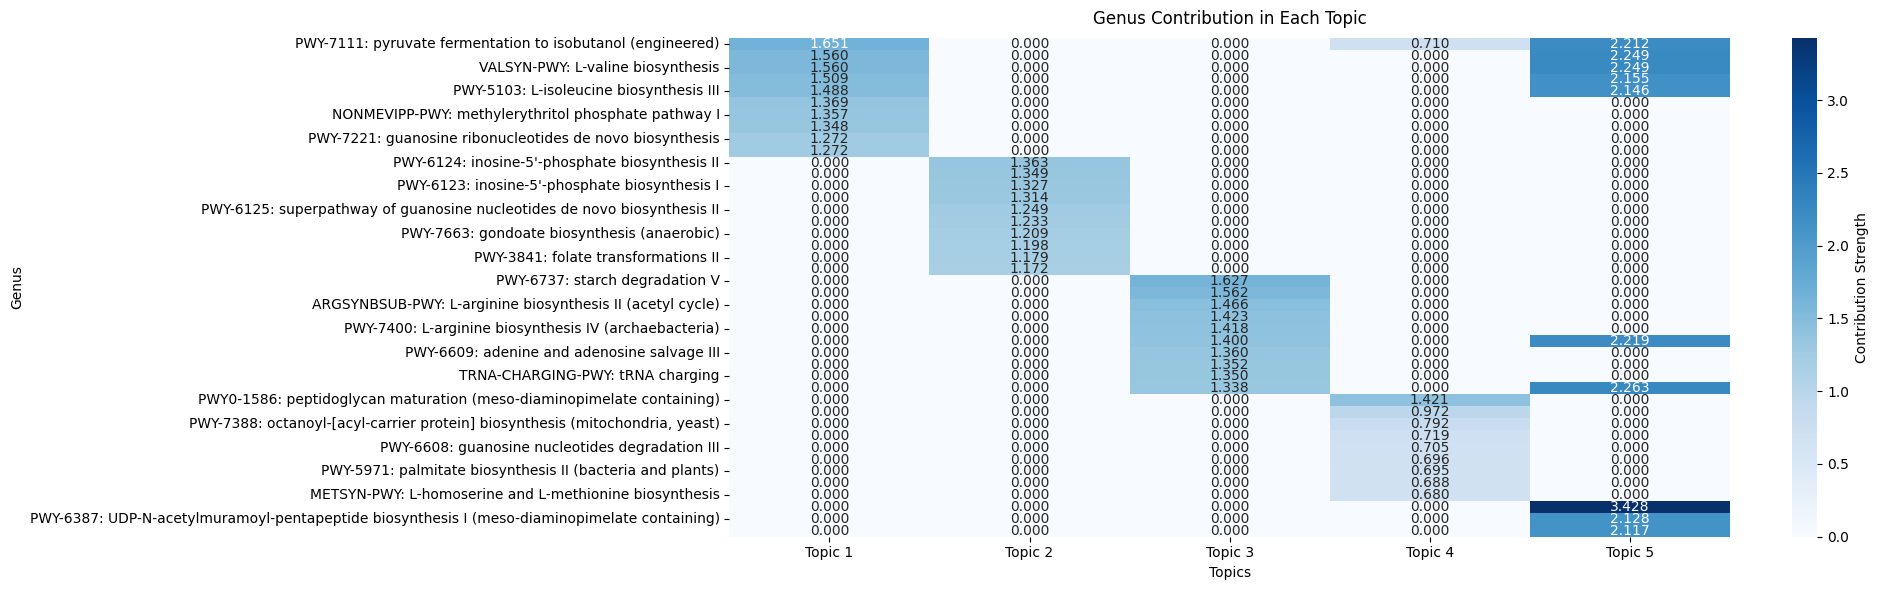

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_topic_contributions(H_matrix, genus_names, n_top_genera=5, n_topics=5, 
                                output_path='/home/zuzannak/MicroFormer/pathways_nmf.png'):
    """
    Visualize the top contributing genera for each topic using a heatmap.
    
    Parameters:
    -----------
    H_matrix : numpy.ndarray
        The H matrix from NMF decomposition
    genus_names : list or Index
        List of genus names corresponding to H matrix columns
    n_top_genera : int, default=5
        Number of top genera to show for each topic
    n_topics : int, default=5
        Number of topics to visualize
    output_path : str, default='taxonomic_nmf.png'
        Path where to save the output figure
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the top genera contributions for each topic
    """
    # Create initial DataFrame with proper labels
    H_df = pd.DataFrame(H_matrix, columns=genus_names).T
    
    # Initialize DataFrame to store top genera
    top_genera_df = pd.DataFrame()
    
    # Get top genera for each topic
    for topic in range(n_topics):
        # Sort and select top genera for current topic
        top_for_topic = H_df[[topic]].sort_values(by=[topic], ascending=False).head(n_top_genera)
        top_genera_df = pd.concat([top_genera_df, top_for_topic], axis=1)
    
    # Rename columns to meaningful topic names
    top_genera_df.columns = [f'Topic {i+1}' for i in range(n_topics)]
    
    # Create visualization
    plt.figure(figsize=(20, 6))
    sns.heatmap(top_genera_df.fillna(0)*100, 
                cmap='Blues',
                annot=True,
                fmt='.3f',
                cbar_kws={'label': 'Contribution Strength'})
    
    plt.title('Genus Contribution in Each Topic', pad=10)
    plt.ylabel('Genus')
    plt.xlabel('Topics')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return top_genera_df

top_genera = visualize_topic_contributions(
    H_matrix=res['H'],
    genus_names=filtered_pathways.columns,
    n_top_genera=10,
    n_topics=5
)

In [17]:
def plot_pcoa(x):
    
    dm = squareform(pdist((np.log(x+1e-3))))
    pcoa_df = pcoa(dm).samples
    return pcoa_df, pcoa(dm)

def get_dominant_signature(W):
    signatures_df = pd.DataFrame(W)
    signatures_df = signatures_df.div(signatures_df.sum(axis=1), axis=0)
    
    dominant_topic = [int(np.argmax(signatures_df.loc[i])) for i in range(len(signatures_df))]
    return dominant_topic

In [18]:
train_pcoa_df, train_x = plot_pcoa(X_train_pathways)
train_dominant_topic = get_dominant_signature(res['W_train'])
print(train_x.proportion_explained[:5])

PC1    0.370802
PC2    0.130737
PC3    0.061256
PC4    0.045472
PC5    0.031006
dtype: float64


<Axes: xlabel='PC4', ylabel='PC5'>

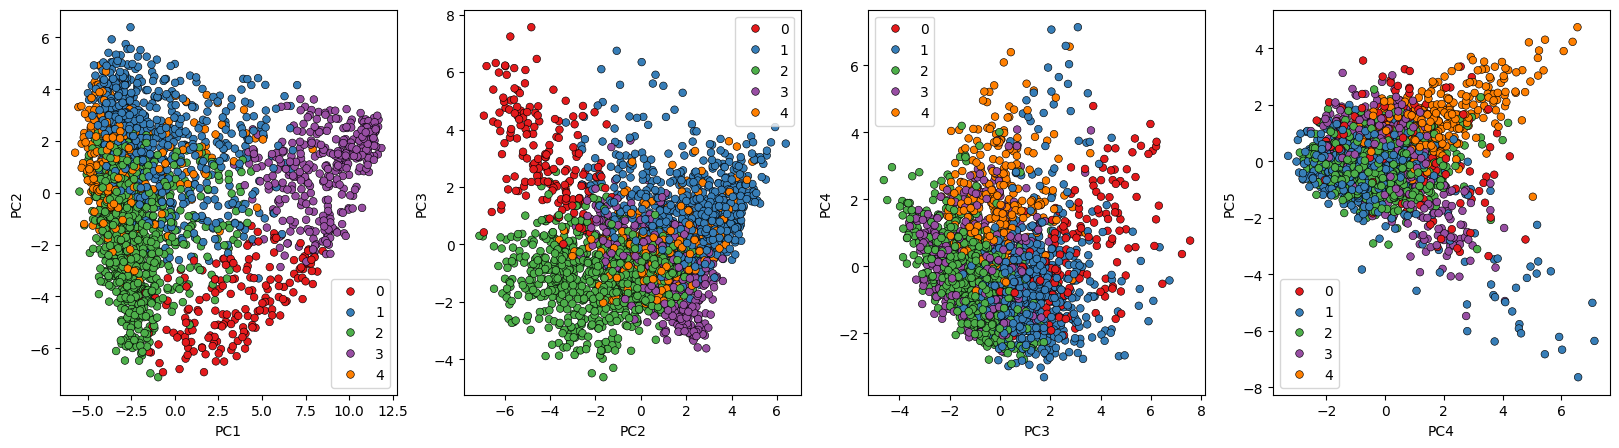

In [19]:
fig, axes = plt.subplots(1, 4, figsize = (20, 5))
sns.scatterplot(x = train_pcoa_df.PC1, y=train_pcoa_df.PC2, hue = train_dominant_topic, palette = 'Set1', edgecolor='k', ax=axes[0], s=30)
sns.scatterplot(x = train_pcoa_df.PC2, y=train_pcoa_df.PC3, hue = train_dominant_topic, palette = 'Set1', edgecolor='k', ax=axes[1], s=30)
sns.scatterplot(x = train_pcoa_df.PC3, y=train_pcoa_df.PC4, hue = train_dominant_topic, palette = 'Set1', edgecolor='k', ax=axes[2], s=30)
sns.scatterplot(x = train_pcoa_df.PC4, y=train_pcoa_df.PC5, hue = train_dominant_topic, palette = 'Set1', edgecolor='k', ax=axes[3], s=30)

In [20]:
test_pcoa_df, test_x = plot_pcoa(X_test_pathways)
test_dominant_topic = get_dominant_signature(res['W_test'])
print(test_x.proportion_explained[:5])

PC1    0.369497
PC2    0.137960
PC3    0.054203
PC4    0.046112
PC5    0.034982
dtype: float64


<Axes: xlabel='PC4', ylabel='PC5'>

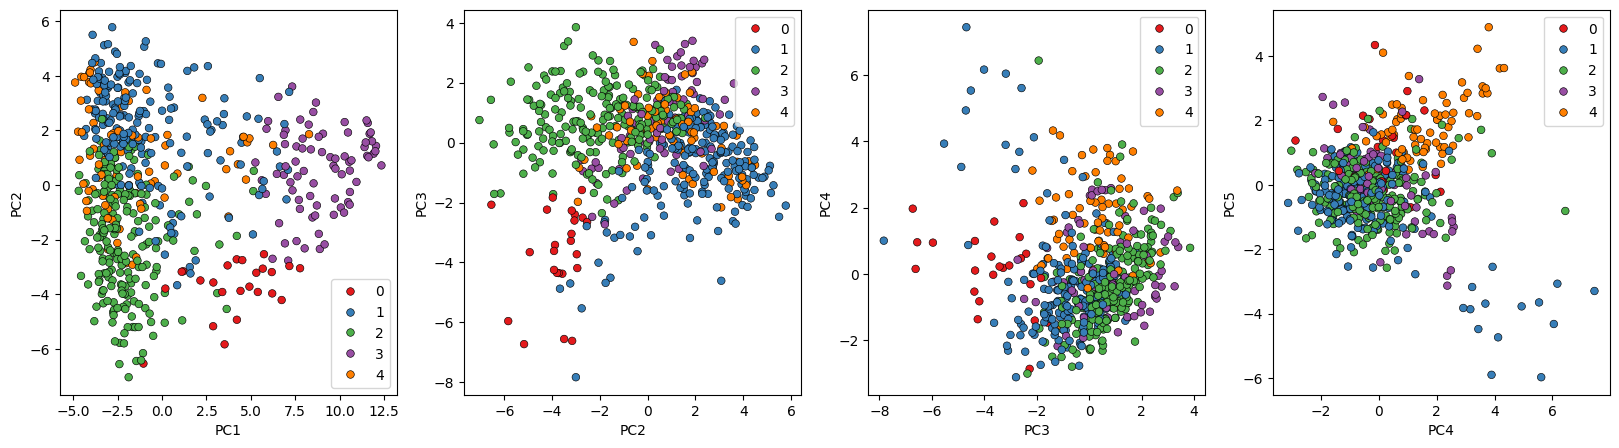

In [21]:
fig, axes = plt.subplots(1, 4, figsize = (20, 5))
sns.scatterplot(x = test_pcoa_df.PC1, y=test_pcoa_df.PC2, hue = test_dominant_topic, palette = 'Set1', edgecolor='k', ax=axes[0], s=30)
sns.scatterplot(x = test_pcoa_df.PC2, y=test_pcoa_df.PC3, hue = test_dominant_topic, palette = 'Set1', edgecolor='k', ax=axes[1], s=30)
sns.scatterplot(x = test_pcoa_df.PC3, y=test_pcoa_df.PC4, hue = test_dominant_topic, palette = 'Set1', edgecolor='k', ax=axes[2], s=30)
sns.scatterplot(x = test_pcoa_df.PC4, y=test_pcoa_df.PC5, hue = test_dominant_topic, palette = 'Set1', edgecolor='k', ax=axes[3], s=30)

In [22]:
pathways_topics = pd.DataFrame(res['W_train'], columns = ['Tf1', 'Tf2', 'Tf3', 'Tf4', 'Tf5'])
pathways_topics['subject_id'] = X_train_pathways.index.tolist()

pathways_topics.to_csv('pathways_topics.csv')

<Axes: xlabel='PC4', ylabel='PC5'>

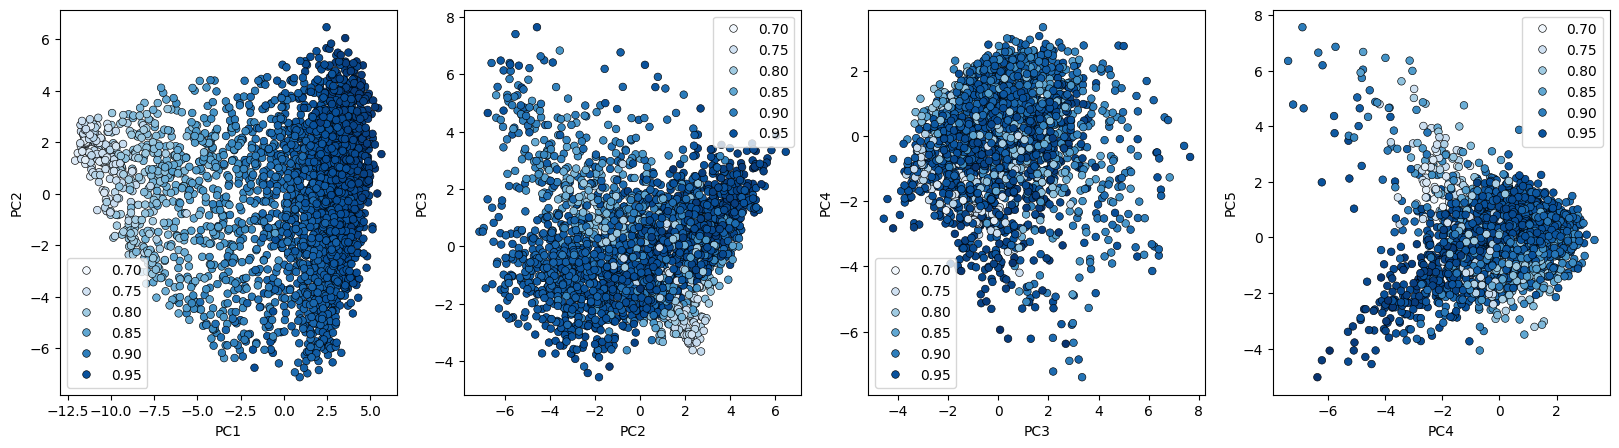

In [23]:
# plot common pathways

pathways = pathways.div(pathways.sum(axis=1), axis=0)
pcoa_all, x_all = plot_pcoa(pathways)

common_pathways_sum = pathways[h_pathways_100prc.pathway].sum(axis=1).values

fig, axes = plt.subplots(1, 4, figsize = (20, 5))
sns.scatterplot(x = pcoa_all.PC1, y=pcoa_all.PC2, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[0], s=30)
sns.scatterplot(x = pcoa_all.PC2, y=pcoa_all.PC3, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[1], s=30)
sns.scatterplot(x = pcoa_all.PC3, y=pcoa_all.PC4, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[2], s=30)
sns.scatterplot(x = pcoa_all.PC4, y=pcoa_all.PC5, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[3], s=30)

<Axes: xlabel='PC4', ylabel='PC5'>

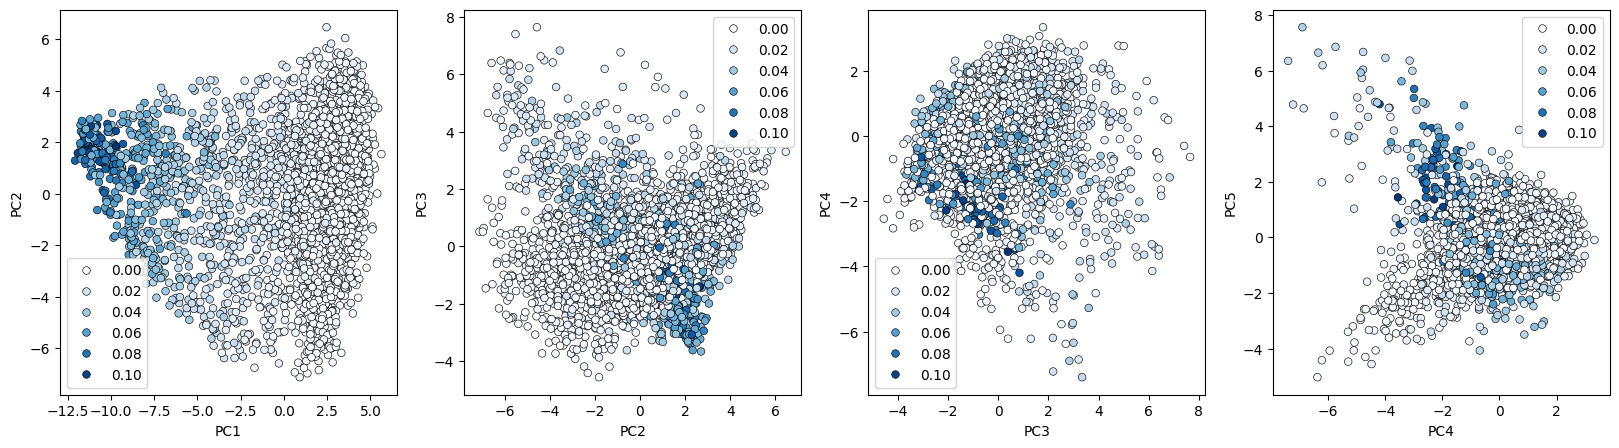

In [27]:
common_pathways_sum = pathways[h_pathways_50prc.pathway].sum(axis=1).values

fig, axes = plt.subplots(1, 4, figsize = (20, 5))
sns.scatterplot(x = pcoa_all.PC1, y=pcoa_all.PC2, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[0], s=30)
sns.scatterplot(x = pcoa_all.PC2, y=pcoa_all.PC3, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[1], s=30)
sns.scatterplot(x = pcoa_all.PC3, y=pcoa_all.PC4, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[2], s=30)
sns.scatterplot(x = pcoa_all.PC4, y=pcoa_all.PC5, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[3], s=30)

<Axes: xlabel='PC4', ylabel='PC5'>

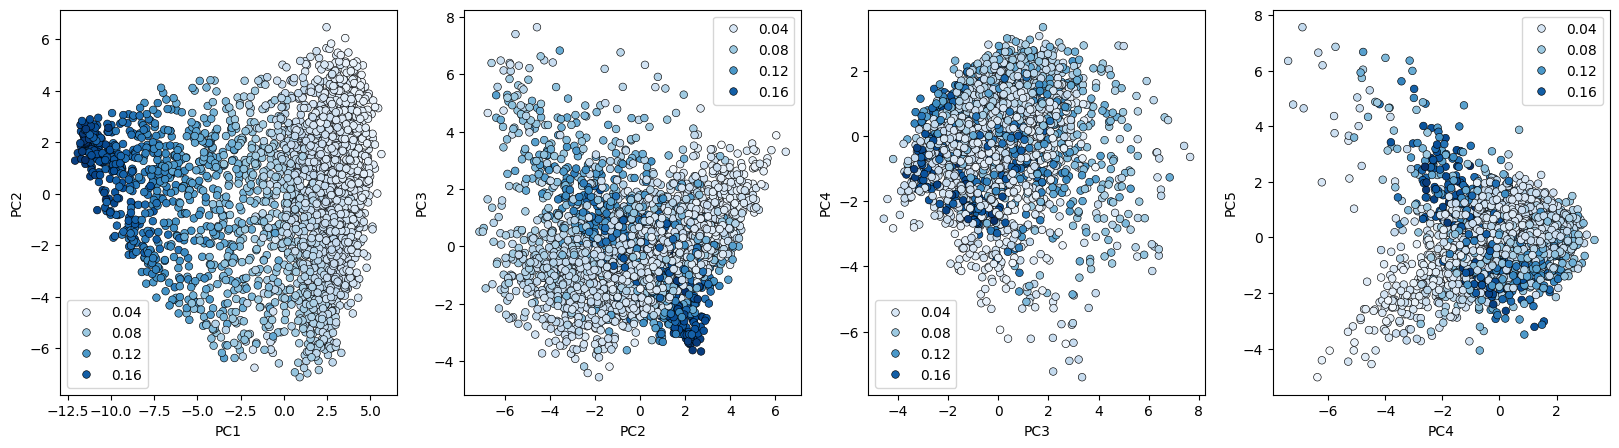

In [28]:
common_pathways_sum = pathways[h_pathways_90prc.pathway].sum(axis=1).values

fig, axes = plt.subplots(1, 4, figsize = (20, 5))
sns.scatterplot(x = pcoa_all.PC1, y=pcoa_all.PC2, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[0], s=30)
sns.scatterplot(x = pcoa_all.PC2, y=pcoa_all.PC3, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[1], s=30)
sns.scatterplot(x = pcoa_all.PC3, y=pcoa_all.PC4, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[2], s=30)
sns.scatterplot(x = pcoa_all.PC4, y=pcoa_all.PC5, hue = common_pathways_sum, palette = 'Blues', edgecolor='k', ax=axes[3], s=30)

<Axes: xlabel='level_1', ylabel='0'>

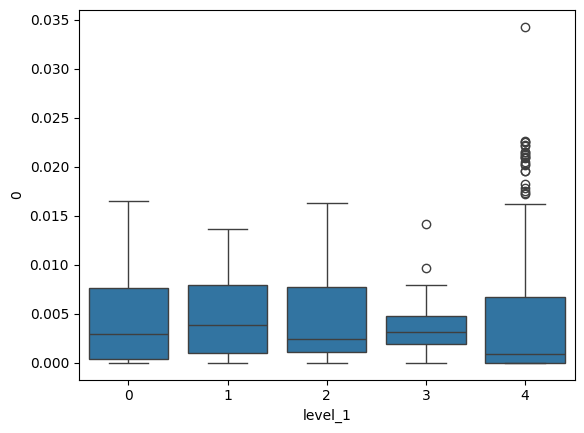

In [59]:
DF = pd.DataFrame(res["H"], columns = filtered_pathways.columns)
df = DF[h_pathways_100prc.pathway].T.stack().reset_index()

sns.boxplot(data=df, x = df['level_1'], y = df[0])

<Axes: xlabel='level_1', ylabel='0'>

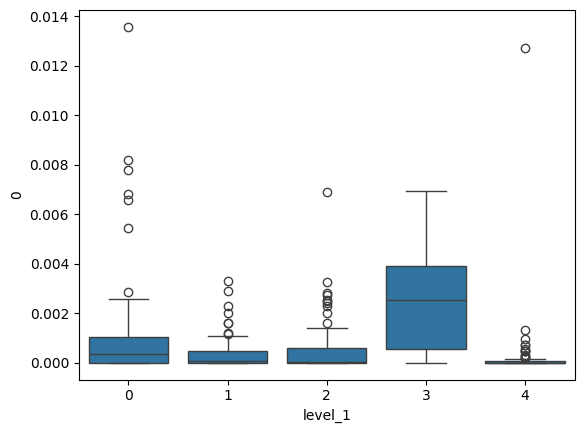

In [60]:
DF = pd.DataFrame(res["H"], columns = filtered_pathways.columns)
df = DF[h_pathways_90prc.pathway].T.stack().reset_index()

sns.boxplot(data=df, x = df['level_1'], y = df[0])

<Axes: xlabel='level_1', ylabel='0'>

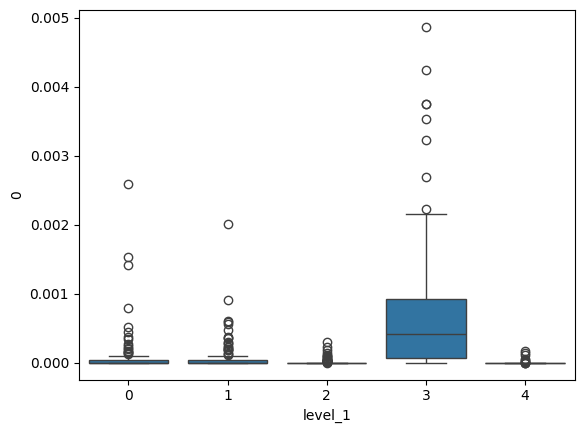

In [64]:
DF = pd.DataFrame(res["H"], columns = filtered_pathways.columns)
df = DF[h_pathways_50prc.pathway].T.stack().reset_index()

sns.boxplot(data=df, x = df['level_1'], y = df[0])